In [168]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 4)
pd.set_option('display.max_columns', 55)
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report,confusion_matrix
import datetime

In [169]:
# My user can't connect to the database anymore, probably because I'm in Brazil
# So I'll try directly with the csvs instead 

## Data wrangling

In [170]:
# Get the database
date_df = pd.read_csv('Merged_Date_Final.csv')
location_df = pd.read_csv('Merged_Location_Final.csv')
crime_df = pd.read_csv('Merged_Crime_Final.csv')
fact_df = pd.read_csv('Fact_Final.csv')
df = pd.concat([date_df, location_df, crime_df, fact_df], axis=1)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [171]:
# Select a subset of the database
df = df.loc[df['City'] == "Vancouver"]
df = df.loc[df['Year'] == 2018]

In [172]:
# Drop columns that are not usefull for the classifier
dropped_columns = \
['Hour',
'Minute',
'Year',
'Longitude',
'Latitude',
'City',
'Crime-rate',
'Crime-report-time',
'Crime-start-time',
'Crime-end-time',
'Crime-key',
'Date-key',
'Location-key',
'Holiday-name',
'IS_CRIME',
'Crime-category',
'Total-neighborhood-population',
'Location-name',
'Years-0-to-4 ',
'Years-5-to-9',
'Years-10-to-14',
'Years-15-to-19',
'Years-15',
'Years-16',
'Years-17',
'Years-18 ',
'Years-19',
'Years-20-to-24',
'Years-25-to-29',
'Years-30-to-34',
'Years-35-to-39',
'Years-40-to-44',
'Years-45-to-49',
'Years-50-to-54',
'Years-55-to-59',
'Years-60-to-64',
'Years-65-to-69',
'Years-70-to-74',
'Years-75-to-79',
'Years-80-to-84',
'Day',
'Years-85-plus']
df.drop(columns=dropped_columns, inplace=True)

In [173]:
# Transform True False into integers
df['Is-Nighttime'] = df['Is-Nighttime'].astype(int)
df['Holiday'] = df['Holiday'].astype(int)
df['Weekend'] = df['Weekend'].astype(int)
df['Is-Traffic'] = df['Is-Traffic'].astype(int)
df['Is-Fatal'] = df['Is-Fatal'].astype(int)

In [174]:
# Check for class imbalance
Counter(df['Is-Nighttime'])

Counter({1: 21862, 0: 16223})

In [175]:
# For DBSCAN
df_reduced = df

In [176]:
df

,Day-of-week,Holiday,Month,Weekend,Neighborhood,Crime-type,Crime-type-severity-index,Is-Traffic,Is-Fatal,Is-Nighttime
3,Friday,0,3,0,West End,Break and Enter Commercial,3,0,0,1
8,Saturday,0,6,1,West End,Break and Enter Commercial,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...
193373,Monday,0,8,0,Mount Pleasant,Vehicle Collision or Pedestrian Struck (with I...,5,1,0,0
193376,Saturday,0,8,1,Mount Pleasant,Vehicle Collision or Pedestrian Struck (with I...,5,1,0,0


In [177]:
# One-hot-encoding
df = pd.get_dummies(df, prefix=["Day-of-week", "Neighborhood", "Crime-type"])

In [178]:
df

,Holiday,Month,Weekend,Crime-type-severity-index,Is-Traffic,Is-Fatal,Is-Nighttime,Day-of-week_Friday,Day-of-week_Monday,Day-of-week_Saturday,Day-of-week_Sunday,Day-of-week_Thursday,Day-of-week_Tuesday,Day-of-week_Wednesday,Neighborhood_Arbutus Ridge,Neighborhood_Central Business District,Neighborhood_Dunbar-Southlands,Neighborhood_Fairview,Neighborhood_Grandview-Woodland,Neighborhood_Hastings-Sunrise,Neighborhood_Kensington-Cedar Cottage,Neighborhood_Kerrisdale,Neighborhood_Killarney,Neighborhood_Kitsilano,Neighborhood_Marpole,Neighborhood_Mount Pleasant,Neighborhood_Musqueam,Neighborhood_Oakridge,Neighborhood_Renfrew-Collingwood,Neighborhood_Riley Park,Neighborhood_Shaughnessy,Neighborhood_South Cambie,Neighborhood_Stanley Park,Neighborhood_Strathcona,Neighborhood_Sunset,Neighborhood_Victoria-Fraserview,Neighborhood_West End,Neighborhood_West Point Grey,Crime-type_Break and Enter Commercial,Crime-type_Break and Enter Residential/Other,Crime-type_Homicide,Crime-type_Mischief,Crime-type_Offence Against a Person,Crime-type_Other Theft,Crime-type_Theft from Vehicle,Crime-type_Theft of Bicycle,Crime-type_Theft of Vehicle,Crime-type_Vehicle Collision or Pedestrian Struck (with Fatality),Crime-type_Vehicle Collision or Pedestrian Struck (with Injury)
3,0,3,0,3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
8,0,6,1,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193373,0,8,0,5,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
193376,0,8,1,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [179]:
# Target clustering for K-means
clusters = df['Is-Nighttime']

In [180]:
# Normalization
df=(df-df.mean())/df.std()

In [181]:
df

,Holiday,Month,Weekend,Crime-type-severity-index,Is-Traffic,Is-Fatal,Is-Nighttime,Day-of-week_Friday,Day-of-week_Monday,Day-of-week_Saturday,Day-of-week_Sunday,Day-of-week_Thursday,Day-of-week_Tuesday,Day-of-week_Wednesday,Neighborhood_Arbutus Ridge,Neighborhood_Central Business District,Neighborhood_Dunbar-Southlands,Neighborhood_Fairview,Neighborhood_Grandview-Woodland,Neighborhood_Hastings-Sunrise,Neighborhood_Kensington-Cedar Cottage,Neighborhood_Kerrisdale,Neighborhood_Killarney,Neighborhood_Kitsilano,Neighborhood_Marpole,Neighborhood_Mount Pleasant,Neighborhood_Musqueam,Neighborhood_Oakridge,Neighborhood_Renfrew-Collingwood,Neighborhood_Riley Park,Neighborhood_Shaughnessy,Neighborhood_South Cambie,Neighborhood_Stanley Park,Neighborhood_Strathcona,Neighborhood_Sunset,Neighborhood_Victoria-Fraserview,Neighborhood_West End,Neighborhood_West Point Grey,Crime-type_Break and Enter Commercial,Crime-type_Break and Enter Residential/Other,Crime-type_Homicide,Crime-type_Mischief,Crime-type_Offence Against a Person,Crime-type_Other Theft,Crime-type_Theft from Vehicle,Crime-type_Theft of Bicycle,Crime-type_Theft of Vehicle,Crime-type_Vehicle Collision or Pedestrian Struck (with Fatality),Crime-type_Vehicle Collision or Pedestrian Struck (with Injury)
3,-0.179123,-1.025476,-0.640452,0.306377,-0.201709,-0.027124,0.861420,2.354738,-0.415755,-0.418964,-0.406064,-0.398089,-0.396273,-0.397469,-0.090736,-0.631413,-0.11226,-0.222399,-0.220049,-0.185806,-0.194697,-0.105215,-0.122712,-0.222854,-0.149167,-0.259160,-0.021132,-0.115221,-0.220245,-0.152626,-0.104831,-0.087898,-0.063717,-0.234613,-0.161404,-0.126515,3.400714,-0.099316,4.219827,-0.25916,-0.019849,-0.421343,-0.300223,-0.386369,-0.806384,-0.245562,-0.176293,-0.018478,-0.200791
8,-0.179123,-0.159653,1.561355,0.306377,-0.201709,-0.027124,0.861420,-0.424664,-0.415755,2.386777,-0.406064,-0.398089,-0.396273,-0.397469,-0.090736,-0.631413,-0.11226,-0.222399,-0.220049,-0.185806,-0.194697,-0.105215,-0.122712,-0.222854,-0.149167,-0.259160,-0.021132,-0.115221,-0.220245,-0.152626,-0.104831,-0.087898,-0.063717,-0.234613,-0.161404,-0.126515,3.400714,-0.099316,4.219827,-0.25916,-0.019849,-0.421343,-0.300223,-0.386369,-0.806384,-0.245562,-0.176293,-0.018478,-0.200791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193373,-0.179123,0.417562,-0.640452,1.375988,4.957512,-0.027124,-1.160843,-0.424664,2.405201,-0.418964,-0.406064,-0.398089,-0.396273,-0.397469,-0.090736,-0.631413,-0.11226,-0.222399,-0.220049,-0.185806,-0.194697,-0.105215,-0.122712,-0.222854,-0.149167,3.858526,-0.021132,-0.115221,-0.220245,-0.152626,-0.104831,-0.087898,-0.063717,-0.234613,-0.161404,-0.126515,-0.294048,-0.099316,-0.236970,-0.25916,-0.019849,-0.421343,-0.300223,-0.386369,-0.806384,-0.245562,-0.176293,-0.018478,4.980180
193376,-0.179123,0.417562,1.561355,1.375988,4.957512,-0.027124,-1.160843,-0.424664,-0.415755,2.386777,-0.406064,-0.398089,-0.396273,-0.397469,-0.090736,-0.631413,-0.11226,-0.222399,-0.220049,-0.185806,-0.194697,-0.105215,-0.122712,-0.222854,-0.149167,3.858526,-0.021132,-0.115221,-0.220245,-0.152626,-0.104831,-0.087898,-0.063717,-0.234613,-0.161404,-0.126515,-0.294048,-0.099316,-0.236970,-0.25916,-0.019849,-0.421343,-0.300223,-0.386369,-0.806384,-0.245562,-0.176293,-0.018478,4.980180


## K-Means

We can't perfectly evaluate clustering if we don't have the labels,
however as this is just an exercise, we do have the labels.
Therefore, we will use those labels to evaluate our clusters

In [182]:
kmeans = KMeans(n_clusters=2)

In [183]:
before = datetime.datetime.now()

In [184]:
# Fit the model to all the data except for the Is-Nighttime label.
kmeans.fit(df.drop('Is-Nighttime',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [185]:
after = datetime.datetime.now()
time_taken = after - before

In [186]:
kmeans.cluster_centers_

array([[ 3.65644258e-03,  8.84847327e-03,  1.19909082e-03,
        -7.63233458e-01, -2.01708796e-01, -2.71241438e-02,
        -2.05703034e-03,  8.64670008e-03, -3.31963220e-03,
         4.95633545e-03, -2.14270869e-03, -6.61543108e-03,
         3.85815231e-04, -1.89014508e-02,  1.82855738e-01,
        -8.29229791e-03,  1.14786230e-02, -1.75730299e-02,
         1.36946315e-02, -1.06302765e-02, -1.80495241e-02,
        -1.03726614e-02, -8.29164106e-03, -2.34705036e-02,
         1.22023852e-02, -1.16417432e-02, -1.51793232e-02,
         2.81111469e-02, -7.47593816e-03, -1.44546496e-02,
        -2.29157234e-03,  2.23597099e-02, -3.13376120e-02,
        -6.25794607e-03, -7.38900928e-03,  6.07260390e-02,
        -1.37089775e-02, -2.36970318e-01, -2.59159546e-01,
        -1.98494505e-02, -4.21342960e-01, -3.00223054e-01,
         3.51070143e-01,  7.32713081e-01, -2.45562138e-01,
        -1.76292742e-01, -1.84783474e-02, -2.00790677e-01],
       [-4.02408335e-03, -9.73815209e-03, -1.31965464e-

In [187]:
df

,Holiday,Month,Weekend,Crime-type-severity-index,Is-Traffic,Is-Fatal,Is-Nighttime,Day-of-week_Friday,Day-of-week_Monday,Day-of-week_Saturday,Day-of-week_Sunday,Day-of-week_Thursday,Day-of-week_Tuesday,Day-of-week_Wednesday,Neighborhood_Arbutus Ridge,Neighborhood_Central Business District,Neighborhood_Dunbar-Southlands,Neighborhood_Fairview,Neighborhood_Grandview-Woodland,Neighborhood_Hastings-Sunrise,Neighborhood_Kensington-Cedar Cottage,Neighborhood_Kerrisdale,Neighborhood_Killarney,Neighborhood_Kitsilano,Neighborhood_Marpole,Neighborhood_Mount Pleasant,Neighborhood_Musqueam,Neighborhood_Oakridge,Neighborhood_Renfrew-Collingwood,Neighborhood_Riley Park,Neighborhood_Shaughnessy,Neighborhood_South Cambie,Neighborhood_Stanley Park,Neighborhood_Strathcona,Neighborhood_Sunset,Neighborhood_Victoria-Fraserview,Neighborhood_West End,Neighborhood_West Point Grey,Crime-type_Break and Enter Commercial,Crime-type_Break and Enter Residential/Other,Crime-type_Homicide,Crime-type_Mischief,Crime-type_Offence Against a Person,Crime-type_Other Theft,Crime-type_Theft from Vehicle,Crime-type_Theft of Bicycle,Crime-type_Theft of Vehicle,Crime-type_Vehicle Collision or Pedestrian Struck (with Fatality),Crime-type_Vehicle Collision or Pedestrian Struck (with Injury)
3,-0.179123,-1.025476,-0.640452,0.306377,-0.201709,-0.027124,0.861420,2.354738,-0.415755,-0.418964,-0.406064,-0.398089,-0.396273,-0.397469,-0.090736,-0.631413,-0.11226,-0.222399,-0.220049,-0.185806,-0.194697,-0.105215,-0.122712,-0.222854,-0.149167,-0.259160,-0.021132,-0.115221,-0.220245,-0.152626,-0.104831,-0.087898,-0.063717,-0.234613,-0.161404,-0.126515,3.400714,-0.099316,4.219827,-0.25916,-0.019849,-0.421343,-0.300223,-0.386369,-0.806384,-0.245562,-0.176293,-0.018478,-0.200791
8,-0.179123,-0.159653,1.561355,0.306377,-0.201709,-0.027124,0.861420,-0.424664,-0.415755,2.386777,-0.406064,-0.398089,-0.396273,-0.397469,-0.090736,-0.631413,-0.11226,-0.222399,-0.220049,-0.185806,-0.194697,-0.105215,-0.122712,-0.222854,-0.149167,-0.259160,-0.021132,-0.115221,-0.220245,-0.152626,-0.104831,-0.087898,-0.063717,-0.234613,-0.161404,-0.126515,3.400714,-0.099316,4.219827,-0.25916,-0.019849,-0.421343,-0.300223,-0.386369,-0.806384,-0.245562,-0.176293,-0.018478,-0.200791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193373,-0.179123,0.417562,-0.640452,1.375988,4.957512,-0.027124,-1.160843,-0.424664,2.405201,-0.418964,-0.406064,-0.398089,-0.396273,-0.397469,-0.090736,-0.631413,-0.11226,-0.222399,-0.220049,-0.185806,-0.194697,-0.105215,-0.122712,-0.222854,-0.149167,3.858526,-0.021132,-0.115221,-0.220245,-0.152626,-0.104831,-0.087898,-0.063717,-0.234613,-0.161404,-0.126515,-0.294048,-0.099316,-0.236970,-0.25916,-0.019849,-0.421343,-0.300223,-0.386369,-0.806384,-0.245562,-0.176293,-0.018478,4.980180
193376,-0.179123,0.417562,1.561355,1.375988,4.957512,-0.027124,-1.160843,-0.424664,-0.415755,2.386777,-0.406064,-0.398089,-0.396273,-0.397469,-0.090736,-0.631413,-0.11226,-0.222399,-0.220049,-0.185806,-0.194697,-0.105215,-0.122712,-0.222854,-0.149167,3.858526,-0.021132,-0.115221,-0.220245,-0.152626,-0.104831,-0.087898,-0.063717,-0.234613,-0.161404,-0.126515,-0.294048,-0.099316,-0.236970,-0.25916,-0.019849,-0.421343,-0.300223,-0.386369,-0.806384,-0.245562,-0.176293,-0.018478,4.980180


In [188]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(clusters,kmeans.labels_))
print(classification_report(clusters,kmeans.labels_))
print("Time taken:", time_taken.total_seconds())

[[ 9399  6824]
 [10555 11307]]
              precision    recall  f1-score   support

           0       0.47      0.58      0.52     16223
           1       0.62      0.52      0.57     21862

   micro avg       0.54      0.54      0.54     38085
   macro avg       0.55      0.55      0.54     38085
weighted avg       0.56      0.54      0.55     38085

Time taken: 0.989418


## DBSCAN

In [189]:
df = df_reduced

In [190]:
df

,Day-of-week,Holiday,Month,Weekend,Neighborhood,Crime-type,Crime-type-severity-index,Is-Traffic,Is-Fatal,Is-Nighttime
3,Friday,0,3,0,West End,Break and Enter Commercial,3,0,0,1
8,Saturday,0,6,1,West End,Break and Enter Commercial,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...
193373,Monday,0,8,0,Mount Pleasant,Vehicle Collision or Pedestrian Struck (with I...,5,1,0,0
193376,Saturday,0,8,1,Mount Pleasant,Vehicle Collision or Pedestrian Struck (with I...,5,1,0,0


In [191]:
# We are going to cluster is-nighttime by crime-type-severity-index
dropped_columns = ['Day-of-week', 'Neighborhood', 'Crime-type']
df.drop(columns=dropped_columns, inplace=True)

In [192]:
# Normalization
df=(df-df.mean())/df.std()

In [193]:
df

,Holiday,Month,Weekend,Crime-type-severity-index,Is-Traffic,Is-Fatal,Is-Nighttime
3,-0.179123,-1.025476,-0.640452,0.306377,-0.201709,-0.027124,0.861420
8,-0.179123,-0.159653,1.561355,0.306377,-0.201709,-0.027124,0.861420
...,...,...,...,...,...,...,...
193373,-0.179123,0.417562,-0.640452,1.375988,4.957512,-0.027124,-1.160843
193376,-0.179123,0.417562,1.561355,1.375988,4.957512,-0.027124,-1.160843


In [194]:
before = datetime.datetime.now()

In [195]:
clustering = DBSCAN().fit(df.values)

In [196]:
after = datetime.datetime.now()
time_taken = after - before
print("Time taken:", time_taken.total_seconds())

Time taken: 8.23498


In [197]:
# Number of elements in each cluster
Counter(clustering.labels_).values()

dict_values([1744, 727, 474, 1356, 24, 26, 8, 14, 12, 5, 11, 7, 11, 56, 2208, 1643, 673, 1025, 31, 16, 43, 21, 19, 24, 5, 5, 16, 13, 1011, 2024, 11, 43, 18, 37, 5, 6426, 2651, 3133, 7111, 33, 123, 126, 91, 91, 59, 27, 16, 52, 15, 437, 447, 1163, 1172, 23, 22, 6, 6, 13, 7, 7, 5, 662, 171, 389, 9, 226])

In [198]:
# Number of clusters
len(Counter(clustering.labels_).values())

66

In [199]:
x = df['Crime-type-severity-index']
y = df['Is-Nighttime']
cluster = clustering.labels_

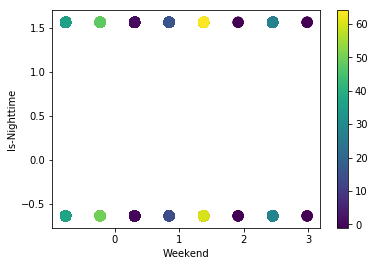

In [200]:
import numpy as np
import matplotlib.pyplot as plt

x = df['Crime-type-severity-index']
y = df['Weekend']
cluster = clustering.labels_

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Weekend')
ax.set_ylabel('Is-Nighttime')
scatter = ax.scatter(x, y, c=cluster, s=100)
plt.colorbar(scatter)

## Conclusion

Compared to our classifier, the K-means algorithm did well, the precision is "only" about 10% lower the clustering.
Our DBSCAN model found 66 clusters, but given the dimensionality of the problem is greater than 2, it's hard to plot the clsuters in a 2d image.